# 1-loop single Higgs production in gluon fusion

# \begin{equation}
    g g \rightarrow H
\end{equation}

The majority of the following lines has been generated using the Mathematica script for this process. The cells are commented when necessary.

First, import all necessary packages.

In [1]:
#!/usr/bin/env python3
import multiprocessing
import os
import subprocess
import sys
import tempfile
import sympy as sp
import numpy as np
import pySecDec as psd

We save the directory of this notebook for later, as we will change the working directory when running the `compile` part.

In [2]:
notebookdir = os.getcwd()

In [3]:
signmap = {
  sp.Symbol('x0'): 1,
  sp.Symbol('x1'): 1,
  sp.Symbol('x2'): 1,
}

In [4]:
def needs_cdeform(name, Fpoly):
  poly = sp.sympify(str(Fpoly))
  terms = sp.Add.make_args(poly.expand())
  res = not all((t.subs(signmap) > 0) == True for t in terms)
  print(f'Needs-Contour-Deformation({name}, {poly}) = {res}')
  return res

In [5]:
def call(f):
  return f()

We define the propagators of the master integrals and the corresponding replacement rules for all relevant scalar products.

In [6]:
b1_propagators = [
  '(l1)^2-1',
  '(l1 - q1)^2-1',
  '(l1 + q2)^2-1'
]

In [7]:
b1_replacement_rules = [
  ('q1*q1', '0'),
  ('q1*q2', 's12/2'),
  ('q2*q2', '0')
]

We now define all relevant master integrals from their propagators, using the `LoopIntegralFromPropagators` function.

In [8]:
def int_0_B1_0_1_1():
  li = psd.loop_integral.LoopIntegralFromPropagators(
    loop_momenta = ['l1'],
    external_momenta = ['q1','q2'],
    propagators = b1_propagators,
    powerlist = [0,1,1],
    replacement_rules = b1_replacement_rules,
    dimensionality = '4-2*eps',
    regulators = ['eps']
  )
  return psd.LoopPackage(
    name = 'B1_0_1_1',
    loop_integral = li,
    real_parameters = ['s12'],
    additional_prefactor = 'I*2^(-4 + 2*eps)*pi^(-2 + eps)',
    decomposition_method = 'iterative',
    form_optimization_level = 4,
    form_work_space = '100M',
    form_threads = 1,
    contour_deformation = needs_cdeform('B1_0_1_1', li.F)
  )

In [9]:
def int_1_B1_1_1_1():
  li = psd.loop_integral.LoopIntegralFromPropagators(
    loop_momenta = ['l1'],
    external_momenta = ['q1','q2'],
    propagators = b1_propagators,
    powerlist = [1,1,1],
    replacement_rules = b1_replacement_rules,
    dimensionality = '4-2*eps',
    regulators = ['eps']
  )
  return psd.LoopPackage(
    name = 'B1_1_1_1',
    loop_integral = li,
    real_parameters = ['s12'],
    additional_prefactor = 'I*2^(-4 + 2*eps)*pi^(-2 + eps)',
    decomposition_method = 'geometric_ku',
    form_optimization_level = 4,
    form_work_space = '100M',
    form_threads = 1,
    contour_deformation = needs_cdeform('B1_1_1_1', li.F)
  )

In the following cells, we define the master integral coefficients and create the corresponding sum package. We then build the _disteval_ library

In [10]:
if __name__ == '__main__':
  # Always start in the directory this file resides in
  thisdir = os.path.dirname(sys.argv[0])
  if thisdir: os.chdir(os.path.dirname(sys.argv[0]))

In [11]:
  make_integrals = [
    int_0_B1_0_1_1,
    int_1_B1_1_1_1,
  ]

In [14]:
  coefficients = {
    "gH*gs^2*ImagI*Na*Tf*flvsumt[1]": {
      0: "(-16*eps*mt1)/(2 - 2*eps)",
      1: "(4*mt1*(-8 - 2*s12 + (4 - 2*eps)*s12))/(2 - 2*eps)",
    },
  }
  try:
    nthreads = int(os.environ['THREADS'])
  except KeyError:
    try:
      nthreads = len(os.sched_getaffinity(0))
    except AttributeError:
      nthreads = os.cpu_count()
  if nthreads > 1:
    with multiprocessing.Pool(nthreads) as pool:
      integrals = pool.map(call, make_integrals)
  else:
    integrals = [f() for f in make_integrals]
  subprocess.check_call(['rm', '-rf', 'disteval'])
  cwd = os.getcwd()
  with tempfile.TemporaryDirectory(prefix='psd') as tmp:
    os.chdir(tmp)
    psd.sum_package('sum',
      integrals,
      coefficients = coefficients,
      regulators = ['eps'],
      requested_orders = [0],
      real_parameters = ['s12'],
      processes = nthreads,
    )
    subprocess.check_call(['make', '-C', 'sum', '-j', str(nthreads), 'disteval.done'])
    subprocess.check_call(['cp', '-a', 'sum/disteval', cwd])
    subprocess.check_call(['rm', '-rf', 'sum'])

Needs-Contour-Deformation(B1_0_1_1, x1**2 + x1*x2*(2 - s12) + x2**2) = True
Needs-Contour-Deformation(B1_1_1_1, x0**2 + 2*x0*x1 + 2*x0*x2 + x1**2 + x1*x2*(2 - s12) + x2**2) = True
running "sum_package" for sum
running "make_package" for "B1_1_1_1"
running "make_package" for "B1_0_1_1"
number of primary sectors before symmetry finding: number of primary sectors before symmetry finding: 3
2
number of primary sectors after symmetry finding (iterative): 2number of primary sectors after symmetry finding (iterative):
 1
number of primary sectors after symmetry finding (light Pak): 1number of primary sectors after symmetry finding (light Pak): 
2
number of primary sectors after symmetry finding (full Pak): number of primary sectors after symmetry finding (full Pak):1
 2
computing Jacobian determinant for primary sector computing Jacobian determinant for primary sector0
 total number sectors before symmetry finding: 1
0total number sectors after symmetry finding (iterative): 1

total number se

We now only need to construct a function out of the _disteval_ library, and we can then evaluate it at any point to see if it matches the analytical result.

In [15]:
from pySecDec.integral_interface import DistevalLibrary

os.chdir(notebookdir)
ggH_1L = DistevalLibrary('disteval/sum.json', verbose=False)

In [16]:
res1 = ggH_1L(parameters={"s12": 2.11426927144226, "mt1": 1.0}, epsrel=1e-4, epsabs=1e-10, format="json")
res2 = ggH_1L(parameters={"s12": 4.523321402575598, "mt1": 1.0}, epsrel=1e-4, epsabs=1e-10, format="json")

In [17]:
result1, result2 = res1['sums']['gH*gs^2*ImagI*Na*Tf*flvsumt[1]'], res2['sums']['gH*gs^2*ImagI*Na*Tf*flvsumt[1]']
print('eps^0 :', -result1[( 0,)][0]/2, '+/- (', -result1[( 0,)][1]/2, ')')
print('eps^0 :', -result2[( 0,)][0]/2, '+/- (', -result2[( 0,)][1]/2, ')')

eps^0 : (-1.0251368548246399e-15+0.010361453077406546j) +/- ( (-1.0317881626553463e-15-7.708751050169005e-16j) )
eps^0 : (-0.003261442304233053+0.03219341118936804j) +/- ( (-6.415834917444141e-16-7.19927640467853e-16j) )


#### Calculating the respective analytical values

In [18]:
def C_0(tau, s_12):
    if tau >= 1:
        return -2/s_12 * np.arcsin(1/np.sqrt(tau))**2
    else:
        return (np.log((1 + np.sqrt(1 - tau))/(1 - np.sqrt(1 - tau))) - np.pi*1j)**2/(2*s_12)


def F_12(m_t, s_12, is_numerical=False, **integral_values):
    x = 4*m_t**2/s_12
    if not is_numerical:
        return 2*m_t*(2 + (4*m_t**2 - s_12)*C_0(x, s_12))
    else:
        return 2*m_t*(2 + (4*m_t**2 - s_12)*integral_values['C_0'])

The results from the equivalent `secdec-private` example are as follows:

$
    -3.2724301726223546 - 1.6046305803662924 \cdot 10^{-13}\,i
    \pm (2.4378856809076865 \cdot 10^{-13} + 2.6160462489896604 \cdot 10^{-13}\,i)
$

$
     -10.167559448341326 - 1.0300526502324199\,i
    \pm (1.5207299254239758 \cdot 10^{-13} + 1.3370262721896051 \cdot 10^{-13}\,i)
$

In [19]:
res_theo = 1j*np.array([F_12(1., 2.11426927144226), F_12(1., 4.523321402575598)])/(16*np.pi**2)
res_sec = 1j*np.array([-3.2724301726223546e+00-1.6046305803662924e-13j, 
                  -1.0167559448341326e+01-1.0300526502324199e+00j])/-2/(16*np.pi**2)
res_alib = -np.array([result1[( 0,)][0], result2[( 0,)][0]])/2

In [20]:
print(res_alib/res_theo)
print(res_alib/res_sec)

[1.+9.89375570e-14j 1.-1.59611015e-14j]
[1.+4.99027268e-14j 1.-1.72678583e-14j]


The numerical integration using `pySecDec` after generating the amplitude form factors using _alibrary_ returns values in line with both the `secdec-private` example as well as the analytical data.

We can now even plot the form factor for continuous values of $s_{12}$:

In [21]:
import matplotlib.pyplot as plt

s12, m12 = np.linspace(2, 6, 100), []
for s_value in s12:
    raw_data = ggH_1L(parameters={"s12": s_value, "mt1": 1.0}, epsrel=1e-4, epsabs=1e-10, format="json")
    m12.append(raw_data['sums']['gH*gs^2*ImagI*Na*Tf*flvsumt[1]'][( 0,)][0])
m12 = -0.5*np.array(m12)

In [22]:
m_theo = []
for s_value in s12:
    m_value = 1j*F_12(1., s_value)/(16*np.pi**2)
    m_theo.append(m_value)
m_theo = np.array(m_theo)

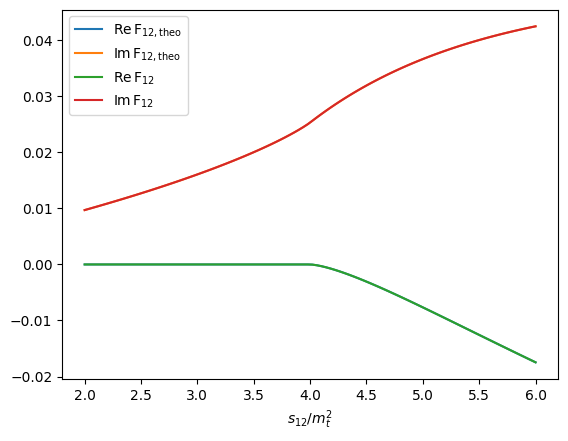

In [24]:
plt.plot(s12, m_theo.real)
plt.plot(s12, m_theo.imag)
plt.plot(s12, m12.real)
plt.plot(s12, m12.imag)
plt.xlabel(r"$s_{12}/m_t^2$")
plt.legend(["$\mathrm{Re\,{F_{12,theo}}}$", "$\mathrm{Im\,{F_{12,theo}}}$", "$\mathrm{Re\,{F_{12}}}$", "$\mathrm{Im\,{F_{12}}}$"])
plt.show()

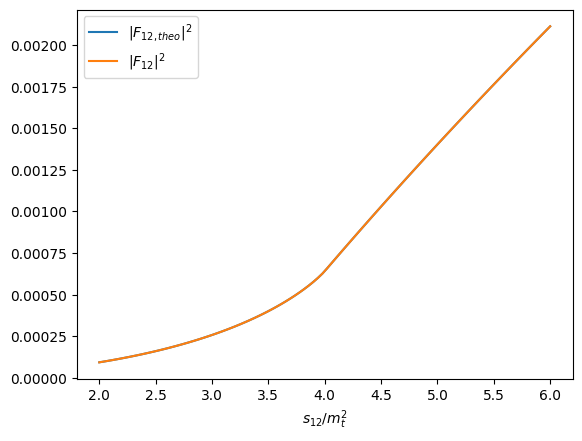

In [25]:
plt.plot(s12, np.abs(m_theo)**2)
plt.plot(s12, np.abs(m12)**2)
plt.xlabel(r"$s_{12}/m_t^2$")
plt.legend(["$|F_{12,theo}|^2$", "$|F_{12}|^2$"])
plt.show()